# Тестовое задание в АВСОФТ

* Необходимо реализовать модель на основе данного датасета
* Для достижения данной цели нужно обработать датасет, привести его в вид, готовый для обучения с помощью модели МЛ (выбор модели зависит только от вас, ограничений на это нет)

Датасет описывает некоторую зависимость числа bugs от
значений repository_name, commit_hash, commit_date,
commit_author, commit_message. Вам необходимо выявить
данную зависимость и написать скрипт/ноутбук, обучающий
модель по данному датасету

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head() # посмотрим, что из себя представляет датасет

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [4]:
data.tail() # посмотрим, что из себя представляет датасет

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1
318,sensor,a4574093,2020-03-23T11:07:07,Dabe,sensor,1


In [5]:
data.info() # проверим на наличие пустых ячеек. Сразу посмотрим сколько строк в датасете.
# null значений не оказалось.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
repository_name    319 non-null object
commit_hash        319 non-null object
commit_date        319 non-null object
commit_author      319 non-null object
commit_message     319 non-null object
bugs               319 non-null int64
dtypes: int64(1), object(5)
memory usage: 15.1+ KB


In [6]:
# хочу заменить значения в ячейках на цифры.
# для начала заменим те значения, где уникальных значений не много. 
for col in list(data.columns):
    print(col, len(data[col].unique()))

repository_name 6
commit_hash 319
commit_date 318
commit_author 10
commit_message 309
bugs 13


In [7]:
data['repository_name'].unique()

array(['mlm', 'standard', 'agent', 'conductor', 'dockers', 'sensor'],
      dtype=object)

In [8]:
# заменим repository_name
repository_name_mapping = {"mlm": 1, "standard": 2, "agent": 3, "conductor": 4, "dockers": 5, "sensor": 6}
data['repository_name'] = data['repository_name'].map(repository_name_mapping)

In [9]:
data['commit_author'].unique()

array(['Victor', 'Peggy', 'Wendy', 'Trudy', 'Mallory', 'Eve', 'Dabe',
       'Carol', 'Bob', 'Alice'], dtype=object)

In [10]:
# Mapping titles
commit_author_mapping = {"Victor": 1, "Peggy": 2, "Wendy": 3, "Trudy": 4, "Mallory": 5,
                        "Eve": 6, "Dabe": 7, "Carol": 8, "Bob": 9, "Alice": 10}
data['commit_author'] = data['commit_author'].map(commit_author_mapping)

In [11]:
data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,1,b28abb42,2020-06-12T14:26:12,1,объяснения предсказаний с помощью lime,4
1,1,438b5c4d,2020-06-12T11:53:10,1,Поставил lime вместо eli5,3
2,1,8e6e4f31,2020-06-11T15:19:03,1,Скрипт для создния пакетов обновления,4
3,1,5e0956a6,2020-06-11T10:42:29,1,Сортировка весов по убыванию,3
4,1,b9f4b40c,2020-06-11T09:25:19,1,не надо конвертировать массив до операции по с...,7


In [12]:
# теперь разделим commit_date на три: одна это месяц, далее день месяца, третья час сделанного коммита
# так как год (2020) не меняется. его учитывать не будем

data['commit_month'] = data['commit_date'].apply(lambda x: int(x[5:7])) #обрежем строку дата под месяц
data['commit_day'] = data['commit_date'].apply(lambda x: int(x[8:10])) #обрежем строку дата под день
data['commit_hour'] = data['commit_date'].apply(lambda x: round(float(x[11:13]) + float(x[14:16])/60, 1)) #обрежем строку дата под часы

In [13]:
# переведем hash в десятичную систему исчесления
data['commit_hash'] = data['commit_hash'].apply(lambda x: int(x, 16))

In [14]:
data['commit_message_len'] = data['commit_message'].apply(len)

In [15]:
# теперь поработаем с комментариями коммитов
# создадим список строк комментарий, преобразованных в список слов в нормальной форме

import re
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

normalized_corpus = [] 
# регулярка для поиска слов
regular_expr = r'\w{3,}' #выбвираем слова, и сразу пропускаем те, которые меньше 3 букв
reg_expr_compiled = re.compile(regular_expr)

for raw_text in data.commit_message.values:
    raw_text_lower = raw_text.lower() # приводим к нижнему регистру
    text_by_words = reg_expr_compiled.findall(raw_text_lower) # разбиваем текст на слова
    normalized_token_list = []
    for word in text_by_words: 
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form #переводим каждое слово в нормальную форму. 
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list) #сохраняем полученный список слов в нормальной форме строки комментария.   
print(normalized_corpus[0])

['объяснение', 'предсказание', 'помощь', 'lime']


In [16]:
data['normalized_commit_message'] = normalized_corpus # вставим эти списки отдельной колонкой


Итак, мы преобразовали слова в каждом доступном докумоменте к нормальной форме. Чтобы было удобнее считать статистиски, преобразуем текстовый корпус в pandas.DataFrame с колонками doc_id | word | dummy где столбец dummy - вспомогательный, он будет содержать всегда единицу

In [17]:
doc_count = len(normalized_corpus)
tokens = []

for row in range(doc_count):
    for token in normalized_corpus[row]:
        tokens.append(token)
        
tokens_df = pd.DataFrame({'word': tokens})
tokens_df['dummy'] = 1

tokens_df.head()

,word,dummy
0,объяснение,1
1,предсказание,1
2,помощь,1
3,lime,1
4,поставить,1


In [18]:
# соберем список слов, которые встречаются более 4 раз. 
word_count_df = tokens_df.groupby(['word'])['dummy'].count().reset_index()
word_count_df_5 = word_count_df[word_count_df.dummy >= 5].sort_values(by='dummy', ascending=False)
word_count_df_5 = word_count_df_5.query("word != 'for' and word != 'для'") # уберем предлог for
word_fives = list(word_count_df_5['word'])

In [19]:
# функция которая возвращает индекс из word_fives слова, если оно есть в этом списке. и -1 если нету.
def word_to_number(x, word_fives):
    count = []
    for word in x:
        if word in word_fives:
            count.append(word_fives.index(word) + 1)
    return min(count) if len(count) > 0 else 0

In [20]:
data['word_fives'] = data['normalized_commit_message'].apply(lambda x: word_to_number(x, word_fives))

In [21]:
# удалим все колонки, которые не цифровые
del_list = ['commit_date', 'commit_message', 'normalized_commit_message']
new_data = data.drop(del_list, axis = 1)
new_data

,repository_name,commit_hash,commit_author,bugs,commit_month,commit_day,commit_hour,commit_message_len,word_fives
0,1,2995436354,1,4,6,12,14.4,38,0
1,1,1133206605,1,3,6,12,11.9,25,0
2,1,2389593905,1,4,6,11,15.3,37,30
3,1,1577670310,1,3,6,11,10.7,28,0
4,1,3119821836,1,7,6,11,9.4,56,0
...,...,...,...,...,...,...,...,...,...
314,6,1528744909,7,1,3,23,12.9,16,0
315,6,2750789459,7,2,3,23,12.5,28,0
316,6,3893713218,7,3,3,23,11.4,42,21
317,6,3880300369,7,1,3,23,11.3,19,1


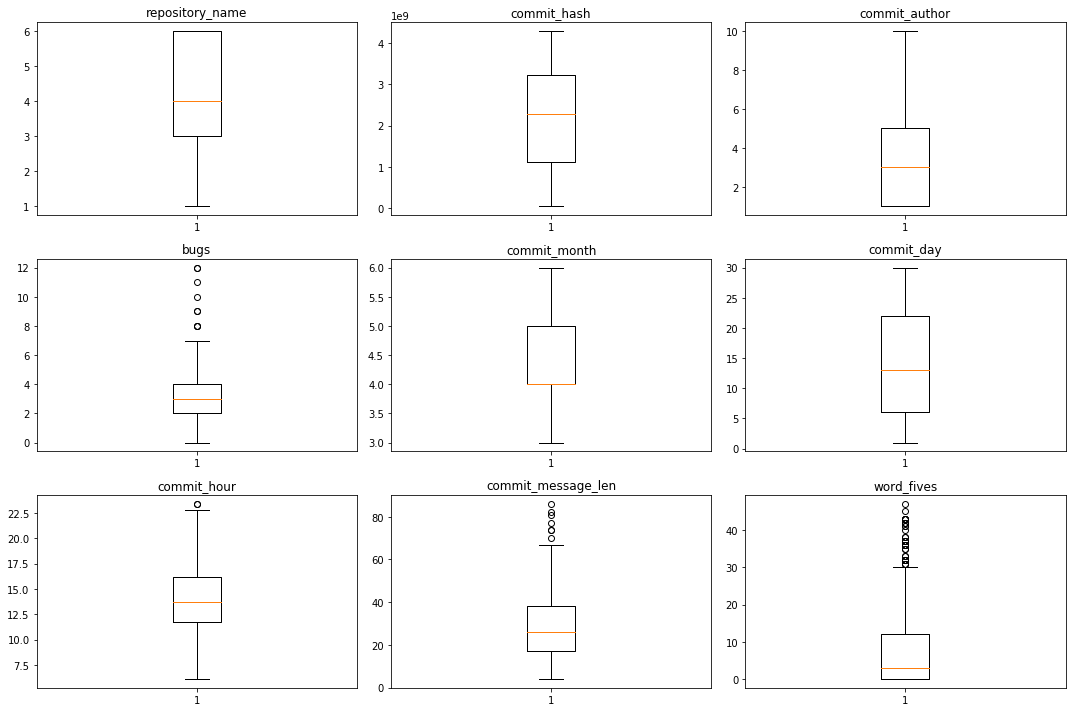

In [22]:
# проверим значения на наличие выбросов.

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
axs = [ax[i, j] for i in range(3) for j in range(3)]
for i, col in enumerate(list(new_data.columns)):
    axs[i].boxplot(new_data[col])
    axs[i].set_title(col)
    plt.tight_layout()


In [23]:
new_data['commit_hour'].max() # проверил часы. Все в порядке. не больше 24. 
# bugs - это target, word_fives и commit_message_len я делал исскусствено, так что проверять не нужно. 

23.4

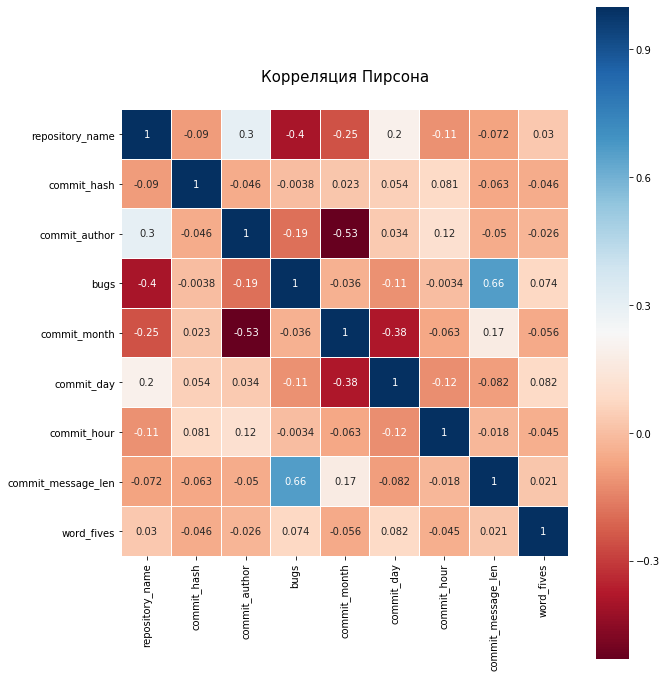

In [24]:
# построим heatmap на основе корреляции Пирсона
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(10,12))
plt.title('Корреляция Пирсона', y=1.05, size=15)
sns.heatmap(new_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# некоторый фикс, чтобы график по краям не обрезался
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!



Признаков, которые бы сильно линейно-коррелировали между собой не наблюдается. Поэтому удалять никакие признаки не будем

In [25]:
new_data.to_csv('new_train.csv')

In [26]:
# почти итоговый датасет для построения модели. Еще предстоит нормолизация train_data
new_data.head()

,repository_name,commit_hash,commit_author,bugs,commit_month,commit_day,commit_hour,commit_message_len,word_fives
0,1,2995436354,1,4,6,12,14.4,38,0
1,1,1133206605,1,3,6,12,11.9,25,0
2,1,2389593905,1,4,6,11,15.3,37,30
3,1,1577670310,1,3,6,11,10.7,28,0
4,1,3119821836,1,7,6,11,9.4,56,0


In [27]:
# импортируем базовые алгориты, и вспомогательные иснтрументы
from sklearn.model_selection import (GridSearchCV, train_test_split, StratifiedKFold)
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier


rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier(случайные деревья)
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC(метод опорных векторов)
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)} # логистическая регрессия

skf = StratifiedKFold(n_splits=5, random_state=17)


In [28]:
# инициализируем наши модели
gbc = GradientBoostingClassifier(random_state = 17)
rfc = RandomForestClassifier(random_state = 17)
svc = SVC(random_state = 17)
lrc = LogisticRegression(random_state = 17)
params = {gbc:gbc_params, rfc:rfc_params, svc:svc_params, lrc:lr_params}


In [29]:
# разделим данные на тренировочные и валидационные
targets = new_data.bugs
data = new_data.drop(columns=['bugs'])
data_norm = (data - data.min()) / (data.max() - data.min()) # нормализация данных
data_train, data_test,  targets_train, targets_test = train_test_split(data_norm, targets, test_size=0.3, random_state=17)

In [30]:
data_train.head() #fast check

,repository_name,commit_hash,commit_author,commit_month,commit_day,commit_hour,commit_message_len,word_fives
29,0.0,0.929838,0.0,0.000000,0.689655,0.265896,0.207317,0.000000
275,1.0,0.149068,0.0,0.333333,0.482759,0.497110,0.378049,0.893617
0,0.0,0.695584,0.0,1.000000,0.379310,0.479769,0.414634,0.000000
81,0.4,0.157255,0.0,0.666667,0.655172,0.421965,0.146341,0.000000
99,0.6,0.461173,0.0,0.666667,0.241379,0.589595,0.426829,0.382979


In [31]:
# настроим параметры и обучим модели

models_grid = []
for model in params:
    model_grid = GridSearchCV(model, params[model], cv=skf)
    model_grid.fit(data_train, targets_train)
    models_grid.append(model_grid)


D:\programms\conda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
D:\programms\conda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\programms\conda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
D:\programms\conda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to Fal

D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to '

In [32]:
model_list = ['GradientBoostingClassifier',
              'RandomForestClassifier',
              'SVC(метод опорных векторов)', 
              'LogisticRegression']

for i, model in enumerate(models_grid):
    print('----------------')
    print("модель: {}, значение accuracy {:.2f}".format(model_list[i], 
                                                accuracy_score(targets_test, model.predict(data_test))))


----------------
модель: GradientBoostingClassifier, значение accuracy 0.47
----------------
модель: RandomForestClassifier, значение accuracy 0.49
----------------
модель: SVC(метод опорных векторов), значение accuracy 0.34
----------------
модель: LogisticRegression, значение accuracy 0.33


Максимальное значение точности у модели, которое я смог добиться: 0,49.
Неудовлетворительно для модели. (может быть из за большого количества групп(13) и небольшого кол-ва данных(319), или что то недоделал с данными)

Можно попробовать разделить target(bugs) на группы. 0-3 = 0, ... 9-12 = 3. (не уверен, что такие действия валидны)
И тогда классификация уже будет по 4-м группам и естественно модели проще будет классифицировать. 


In [33]:
def group_bugs(x):
    if x == 12:
        return 3
    else:
        return x//3
new_data['group_bugs'] = new_data['bugs'].apply(lambda x: group_bugs(x)) # сама группировка
new_data.group_bugs.unique()

array([1, 2, 0, 3], dtype=int64)

In [34]:
# разделим данные на тренировочные и валидационные только уже с group_bugs
targets = new_data.group_bugs
data = new_data.drop(columns=['bugs', 'group_bugs'])
# нормализация данных (потом попробуем без неё)
data_norm = (data - data.min()) / (data.max() - data.min())
data_train, data_test,  targets_train, targets_test = train_test_split(data_norm, targets, test_size=0.3, random_state=17)

In [35]:
models_grid = []
for model in params:
    model_grid = GridSearchCV(model, params[model], cv=skf)
    model_grid.fit(data_train, targets_train)
    models_grid.append(model_grid)


D:\programms\conda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\programms\conda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\programms\conda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma wil

D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\programms\conda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to '

In [36]:
for i, model in enumerate(models_grid):
    print('----------------')
    print("модель: {}, значение accuracy {:.2f}".format(model_list[i], 
                                                accuracy_score(targets_test, model.predict(data_test))))

----------------
модель: GradientBoostingClassifier, значение accuracy 0.76
----------------
модель: RandomForestClassifier, значение accuracy 0.81
----------------
модель: SVC(метод опорных векторов), значение accuracy 0.81
----------------
модель: LogisticRegression, значение accuracy 0.74


И в итоге получаем максимальное значение точности у модели для групированного таргета(bugs): 0,81.
Что уже удовлетворительно для модели. 